Veri Yüklendi: (5500, 13)

--- Hedef Değişken Sınıflandırılıyor ---
Risk Grupları Dağılımı:
Risk_Category
Düşük Risk     1834
Orta Risk      1833
Yüksek Risk    1833
Name: count, dtype: int64

Modelden saklanan/silinen sütunlar: ['Mental_Health_Score', 'Source']

--- Kategorik Veriler Sayısallaştırılıyor (Label Encoding) ---
 - Gender dönüştürüldü: [('female', 0), ('male', 1)] ...
 - Relationship_Status dönüştürüldü: [('complicated', 0), ('in relationship', 1), ('married', 2), ('single', 3)] ...
 - Academic_Level dönüştürüldü: [('graduate', 0), ('high school', 1), ('undergraduate', 2)] ...
 - Most_Used_Platform dönüştürüldü: [('facebook', 0), ('instagram', 1), ('kakaotalk', 2), ('line', 3), ('linkedin', 4)] ...
 - Affects_Academic_Performance dönüştürüldü: [('no', 0), ('yes', 1)] ...
 - Conflicts_Over_Social_Media dönüştürüldü: [('0', 0), ('1', 1), ('2', 2), ('3', 3), ('4', 4)] ...
 - Risk_Category dönüştürüldü: [('Düşük Risk', 0), ('Orta Risk', 1), ('Yüksek Risk', 2)] ...

--- Sayısal

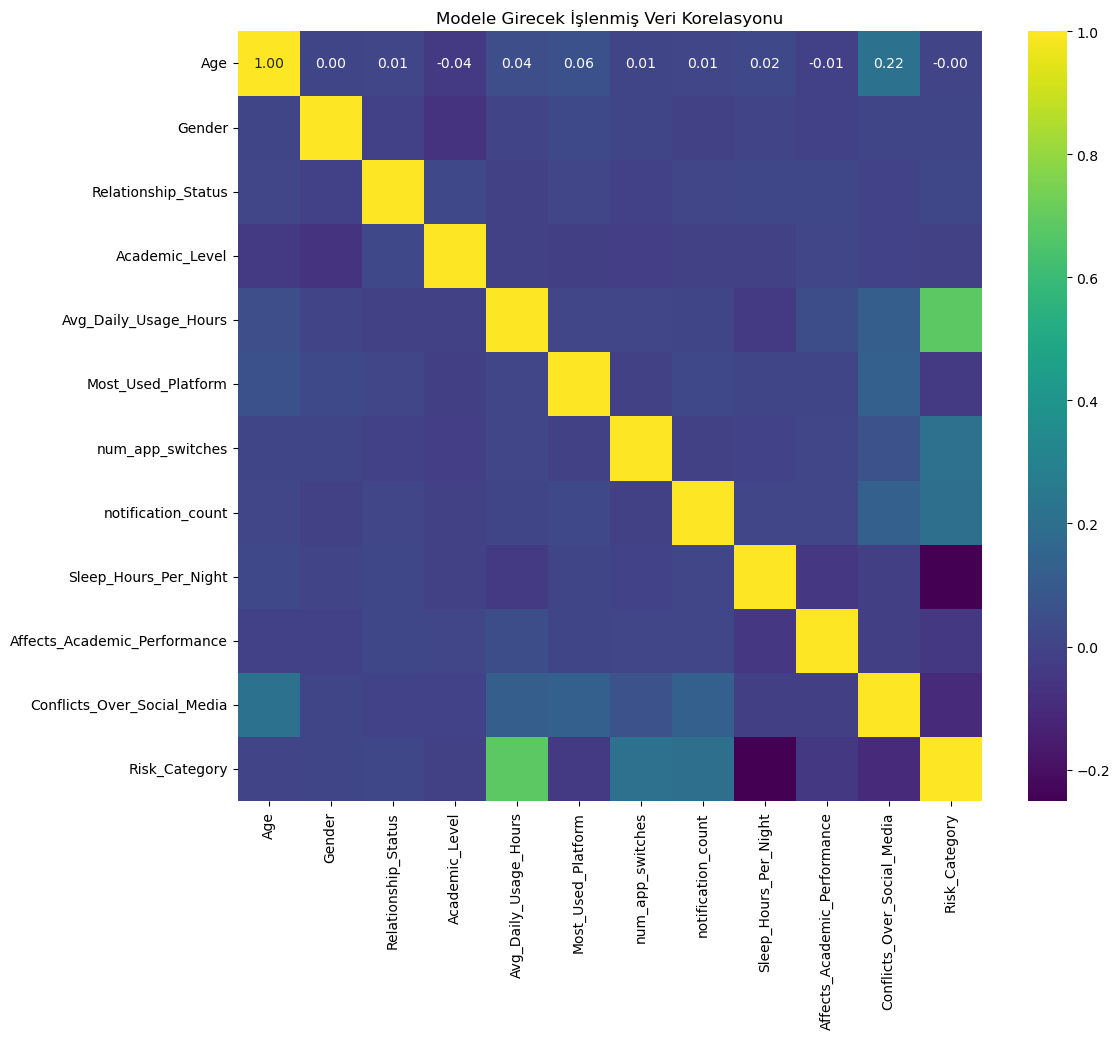

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import os

# --- AYARLAR ---
input_path = '../data/final_merged_data_fixed.csv'   # Önceki adımdan gelen temiz dosya
output_path = '../data/model_ready_data.csv'         # Modele girecek final dosya
img_save_dir = '../images'

if not os.path.exists(img_save_dir):
    os.makedirs(img_save_dir)

# --- 1. YÜKLEME ---
if os.path.exists(input_path):
    df = pd.read_csv(input_path)
    print(f"Veri Yüklendi: {df.shape}")
else:
    print("❌ Hata: Dosya bulunamadı.")
    df = None

if df is not None:
    # --- 2. HEDEF DEĞİŞKENİ SINIFLANDIRMA (Binning) ---
    # Mental Skoru (0-1 arası) 3 risk grubuna ayırıyoruz.
    # qcut: Her gruba eşit sayıda insan düşmesini sağlar (Veri Dengesi için).
    print("\n--- Hedef Değişken Sınıflandırılıyor ---")
    
    df['Risk_Category'] = pd.qcut(df['Mental_Health_Score'], q=3, labels=['Düşük Risk', 'Orta Risk', 'Yüksek Risk'])
    
    print("Risk Grupları Dağılımı:")
    print(df['Risk_Category'].value_counts())
    
    # Artık sayısal Skora ihtiyacımız kalmadı (Çünkü sınıf tahmin edeceğiz),
    # Ayrıca 'Source' bilgisini de modele vermiyoruz (Ezberi önlemek için).
    drop_cols = ['Mental_Health_Score', 'Source', 'Source_Code']
    # Varsa sil (Hata vermemesi için kontrol edip siliyoruz)
    cols_to_drop = [c for c in drop_cols if c in df.columns]
    df.drop(columns=cols_to_drop, inplace=True)
    
    print(f"\nModelden saklanan/silinen sütunlar: {cols_to_drop}")

    # --- 3. ENCODING (Yazıları Sayıya Çevirme) ---
    print("\n--- Kategorik Veriler Sayısallaştırılıyor (Label Encoding) ---")
    
    label_encoders = {}
    
    # Hangi sütunlar yazı (object) veya kategori?
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le # İleride "0 ne demekti?" diye bakmak için saklıyoruz
        
        # İlk 3 dönüşümü ekrana yazalım ki ne yaptığını gör
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        # Çok uzunsa kısaltarak göster
        preview = list(mapping.items())[:5] 
        print(f" - {col} dönüştürüldü: {preview} ...")

    # --- 4. SCALING (Ölçeklendirme) ---
    # SVM ve KNN gibi modeller için sayıların büyüklüğü önemlidir.
    # Yaş (20) ile Bildirim (100) aynı terazide tartılsın diye Standartlaştırıyoruz.
    print("\n--- Sayısal Veriler Ölçekleniyor (StandardScaler) ---")
    
    # Risk_Category (Hedef) hariç diğerlerini ölçekle
    feature_cols = [c for c in df.columns if c != 'Risk_Category']
    
    scaler = StandardScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    
    print("Tüm özellikler (X) standartlaştırıldı (Ortalama=0, Varyans=1 yapıldı).")

    # --- 5. SON KONTROL VE KAYIT ---
    print("\n--- Final Veri Seti (İlk 5 Satır) ---")
    print(df.head())
    
    # Kaydet
    df.to_csv(output_path, index=False)
    print(f"\n✅ Modele Hazır Veri Kaydedildi: {output_path}")
    print(f"Final Boyut: {df.shape}")
    
    # --- 6. İŞLENMİŞ VERİ KORELASYONU ---
    # İşlenmiş verinin son bir fotoğrafını çekelim
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='viridis')
    plt.title('Modele Girecek İşlenmiş Veri Korelasyonu')
    plt.savefig(f"{img_save_dir}/Processed_Data_Correlation.png")
    plt.show()